In [1]:
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

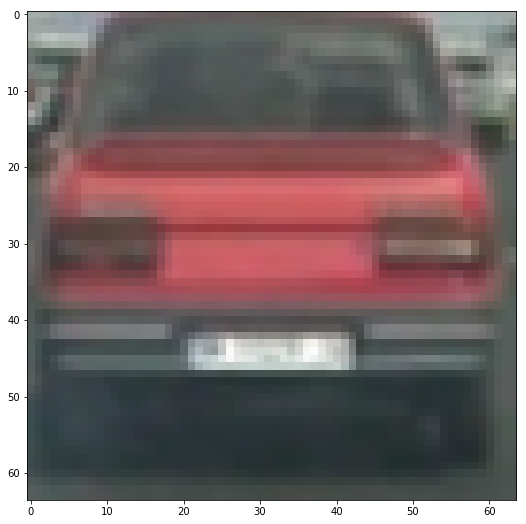

In [2]:
test_img_name = './data/vehicles/GTI_Right/image0199.png'
test2 = plt.imread('./examples/sliding_windows.jpg')

test_img = plt.imread(test_img_name)
f = plt.figure(figsize=(16,9))
scaled_test = np.uint8(255*test_img/np.max(test_img))
plt.imshow(test_img)

In [79]:
def color_hist(img, cspace='RGB', nbins=32, bins_range=(0, 256)):
    """
    Assuming RGB image input.
    """
    # Convert Color Space
    if cspace == 'HLS':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif cspace == 'HSV':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    else:
        pass
    # Compute the histogram of the RGB channels separately
    
    ch1_hist = np.histogram(img[:,:,0], bins=32, range=(0, 256))
    ch2_hist = np.histogram(img[:,:,1], bins=32, range=(0, 256)) 
    ch3_hist = np.histogram(img[:,:,2], bins=32, range=(0, 256))
    
    # Generating bin centers
    bin_edges = ch1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return ch1_hist, ch2_hist, ch3_hist, bin_centers, hist_features

(96,)


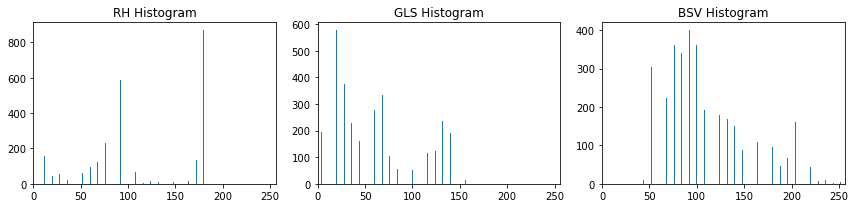

In [82]:
rh, gh, bh, bincen, color_feature_vec = color_hist(scaled_test, cspace='HSV', nbins=32, bins_range=(0, 256))

print(color_feature_vec.shape)

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('RH Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('GLS Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('BSV Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

(3072,)


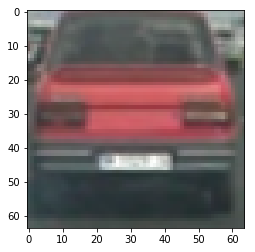

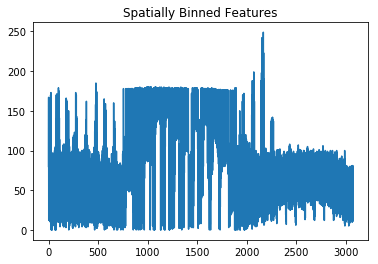

In [85]:
def bin_spatial(img, cspace='RGB', size=(32, 32)):
    small_img = cv2.resize(img, size)
    # Convert Color Space
    if cspace == 'HLS':
        small_img = cv2.cvtColor(small_img, cv2.COLOR_RGB2HLS)
    elif cspace == 'HSV':
        small_img = cv2.cvtColor(small_img, cv2.COLOR_RGB2HSV)
    else:
        pass
    # Use cv2.resize().ravel() to create the feature vector
    features = small_img.ravel() # Remove this line!
    # Return the feature vector
    return features
    
raw_feature_vec = bin_spatial(scaled_test, cspace='HLS', size=(32, 32))
print(raw_feature_vec.shape)

# Plot features
plt.imshow(scaled_test)
plt.show()
plt.plot(raw_feature_vec)
plt.title('Spatially Binned Features')

In [89]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features

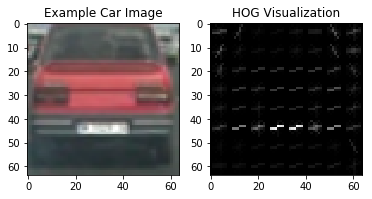

In [90]:
# gray = cv2.cvtColor(scaled_test, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(scaled_test, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(scaled_test, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [91]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), orient=9, pix_per_cell=8, cell_per_block=2):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img_name in imgs:
        # Read in each one by one
        img = plt.imread(img_name)
        # apply color conversion if other than 'RGB'
        # Apply bin_spatial() to get spatial color features
        raw_features = bin_spatial(img, cspace=cspace)
        # Apply color_hist() to get color histogram features
        _, _, _, _, color_features = color_hist(img, cspace=cspace)
        # Get hog features
        hog_features = get_hog_features(img, orient, pix_per_cell, cell_per_block)
        
        # Append the new feature vector to the features list
        feature = np.concatenate((raw_features, color_features, hog_features))
        features.append(feature)
    # Return list of feature vectors
    return features

In [63]:
import glob

notcar_names = glob.glob('./data/non-vehicles/Extras/*.png')
notcar_names.extend(glob.glob('./data/non-vehicles/GTI/*.png'))

car_names = glob.glob('./data/vehicles/GTI_Far/*.png')
car_names.extend(glob.glob('./data/vehicles/GTI_Left/*.png'))
car_names.extend(glob.glob('./data/vehicles/GTI_MiddleClose/*.png'))
car_names.extend(glob.glob('./data/vehicles/GTI_Right/*.png'))
car_names.extend(glob.glob('./data/vehicles/KITTI_extracted/*.png'))

print("Number of car samples: {}".format(len(car_names)))
print("Number of not car samples: {}".format(len(notcar_names)))

Number of car samples: 8792
Number of not car samples: 8968


In [95]:
# Get car feature data
car_feature_RGB = np.asarray(extract_features(car_names, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)))
car_feature_HLS = np.asarray(extract_features(car_names, cspace='HLS', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)))
car_feature_HSV = np.asarray(extract_features(car_names, cspace='HSV', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)))

car_feature_data = np.concatenate((car_feature_RGB, car_feature_HLS, car_feature_HSV), axis=1)

# Get non-car feature data
notcar_feature_RGB = np.asarray(extract_features(notcar_names, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)))
notcar_feature_HLS = np.asarray(extract_features(notcar_names, cspace='HLS', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)))
notcar_feature_HSV = np.asarray(extract_features(notcar_names, cspace='HSV', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)))

notcar_feature_data = np.concatenate((notcar_feature_RGB, notcar_feature_HLS, notcar_feature_HSV), axis=1)

In [96]:
print(car_feature_data.shape)
print(notcar_feature_data.shape)

(8792, 14796)
(8968, 14796)


In [103]:
data_X = np.concatenate((car_feature_data, notcar_feature_data), axis=0).astype(np.float64)

In [100]:
data_X.shape

(17760, 14796)

In [102]:
from scipy.stats import describe

data_y = np.zeros((len(car_feature_data) + len(notcar_feature_data), ))
data_y[:len(car_feature_data)] = 1

8792.0

In [105]:
from sklearn.preprocessing import StandardScaler

data_X_normalized = StandardScaler().fit_transform(data_X)

In [107]:
print(data_X_normalized.shape)

(17760, 14796)


In [ ]:
import time
from sklearn.decomposition import PCA
import pandas as pd

def pca_transform_reconstruct(fit_data, trans_data, pca_dim):
    start_time = time.time()
    
    pca = PCA(n_components=pca_dim)
    pca.fit(fit_data)

    data_pca = pca.transform(trans_data)
    data_pca = pd.DataFrame(data=data_pca)

    cp_imp = pca.explained_variance_ratio_
    cp_imp = pd.Series(cp_imp)
    cp_imp_cum = cp_imp.cumsum()
    
    cp_imp_cum.plot(figsize=(8, 6))
    print(cp_imp_cum.iloc[-1])
    print("Fitting PCA took {} seconds".format(time.time() - start_time))

    return data_pca

X_pca = pca_transform_reconstruct(data_X_normalized, data_X_normalized, 5000)